# ABEL linac tracking example

By Carl A. Lindstrøm (University of Oslo), 8 Sep 2023

### Import ABEL framework

In [1]:
import sys
sys.path.append('../')
from abel import *
#from abel.classes.stage.impl import stage_quasistatic_2d_radiation_reaction as rr
import numpy as np
import matplotlib.pyplot as plt
from abel.utilities.statistics import prct_clean, prct_clean2d
from matplotlib.animation import FuncAnimation
import time

initializing ocelot...


### Define the linac and beams

In [2]:
# Updated params
# define driver
driver = SourceBasic()
driver.charge = -2.7e10 * SI.e # [C]
driver.energy = 31.25e9 # [eV]
driver.rel_energy_spread = 0.01
driver.bunch_length = 50e-6 # [m]
driver.z_offset = 580e-6 # [m]
driver.emit_nx, driver.emit_ny = 10e-6, 10e-6 # [m rad]
driver.beta_x, driver.beta_y = 30e-3, 30e-3 # [m]
driver.num_particles = 100000
driver.jitter.x = 0 # [m] 2e-6
driver.jitter.y = 0 # [m] 100e-9
driver.jitter.t = 0 # 10e-15 # [m]

# define stage
stage = StageQuasistatic2dRadiationReaction()
stage.driver_source = driver
stage.length = 11 # [m]
stage.nom_energy_gain = 31.9e9/(11/stage.length) # [eV]
stage.plasma_density = 2e21 # [m^-3]
stage.ramp_beta_mag = 5
stage.enable_rr = True

# define first stage (half length)
first_stage = StageQuasistatic2dRadiationReaction()
first_stage.driver_source = stage.driver_source
first_stage.nom_energy_gain = stage.nom_energy_gain/2
first_stage.length = stage.length/2
first_stage.plasma_density = stage.plasma_density
first_stage.ramp_beta_mag = stage.ramp_beta_mag
first_stage.enable_rr = stage.enable_rr

# define beam
source = SourceBasic()
source.charge = -1e10 * SI.e # [C]
source.energy = 470e9 # [eV]
source.rel_energy_spread = 0.01
source.bunch_length = 28e-6 # [m]
source.z_offset = 0e-6 # [m]
source.emit_nx, source.emit_ny = 160e-6, 0.56e-6 # [m rad]
source.beta_x = stage.matched_beta_function(energy = source.energy)
source.beta_y = source.beta_x
source.num_particles = 10000
source.jitter.t = driver.jitter.t

# define interstage
interstage = InterstageBasic()
interstage.beta0 = lambda E: stage.matched_beta_function(E)
interstage.dipole_length = lambda E: 1 * np.sqrt(E/10e9) # [m(eV)]
interstage.dipole_field = 1 # [T]

# beam delivery system
bds = BeamDeliverySystemBasic()
bds.beta_x, bds.beta_y = 8e-3, 0.4e-3 # [m]
bds.bunch_length = 0.75 * bds.beta_y

# define linac
linac = Linac()
linac.source = source
linac.stage = stage
linac.first_stage = first_stage
linac.interstage = interstage
linac.num_stages = 1

### Run simulations

In [3]:
start = time.process_time()

name = f'linac_{int(source.energy/1e9)}GeV_{interstage.dipole_field}T_\
ex_{source.emit_nx*1e6}_jitterx_{driver.jitter.x}\
_jittery_{driver.jitter.y}_N_{linac.num_stages}\
_RR_{stage.enable_rr}_11m'#_Hills_stage'

linac.run(name, num_shots=1, overwrite=True, parallel=False);

print((time.process_time() - start)/60)

Tracking element 1 (s = 0.0 m, -1.60 nC, 5.0 GeV, SourceBasic, stage 0)


/pfs/lustrep2/scratch/project_465000445/kalvik/master_kalvik/lib/python3.9/site-packages/aptools/data_analysis/beam_diagnostics.py:524: RuntimeWarning: invalid value encountered in sqrt
  em_x = np.sqrt(np.linalg.det(cov_x.astype(np.float32, copy=False)))


Tracking element 2 (s = 5.5 m, -1.60 nC, 21.5 GeV, StageQuasistatic2dRadiationReaction, stage 1)
Tracking element 3 (s = 12.4 m, -1.60 nC, 21.5 GeV, InterstageBasic, stage 1)
Tracking element 4 (s = 23.4 m, -1.60 nC, 53.5 GeV, StageQuasistatic2dRadiationReaction, stage 2)
Tracking element 5 (s = 34.4 m, -1.60 nC, 53.5 GeV, InterstageBasic, stage 2)
Tracking element 6 (s = 45.4 m, -1.60 nC, 85.2 GeV, StageQuasistatic2dRadiationReaction, stage 3)
Tracking element 7 (s = 59.4 m, -1.60 nC, 85.2 GeV, InterstageBasic, stage 3)
Tracking element 8 (s = 70.4 m, -1.60 nC, 116.9 GeV, StageQuasistatic2dRadiationReaction, stage 4)
Tracking element 9 (s = 86.7 m, -1.60 nC, 116.9 GeV, InterstageBasic, stage 4)
Tracking element 10 (s = 97.7 m, -1.60 nC, 148.4 GeV, StageQuasistatic2dRadiationReaction, stage 5)
Tracking element 11 (s = 116.2 m, -1.60 nC, 148.4 GeV, InterstageBasic, stage 5)


/pfs/lustrep2/scratch/project_465000445/kalvik/thesis_scripts/ABEL_dev/abel/utilities/relativity.py:22: RuntimeWarning: invalid value encountered in sqrt
  return np.sign(gamma) * np.sqrt(1-1/gamma**2)


Tracking element 12 (s = 127.2 m, -1.60 nC, 180.0 GeV, StageQuasistatic2dRadiationReaction, stage 6)
Tracking element 13 (s = 147.5 m, -1.60 nC, 180.0 GeV, InterstageBasic, stage 6)
Tracking element 14 (s = 158.5 m, -1.60 nC, 211.6 GeV, StageQuasistatic2dRadiationReaction, stage 7)
Tracking element 15 (s = 180.6 m, -1.60 nC, 211.6 GeV, InterstageBasic, stage 7)
Tracking element 16 (s = 191.6 m, -1.60 nC, 243.2 GeV, StageQuasistatic2dRadiationReaction, stage 8)
Tracking element 17 (s = 215.2 m, -1.60 nC, 243.2 GeV, InterstageBasic, stage 8)
Tracking element 18 (s = 226.2 m, -1.60 nC, 274.8 GeV, StageQuasistatic2dRadiationReaction, stage 9)
Tracking element 19 (s = 251.4 m, -1.60 nC, 274.8 GeV, InterstageBasic, stage 9)
Tracking element 20 (s = 262.4 m, -1.60 nC, 306.4 GeV, StageQuasistatic2dRadiationReaction, stage 10)
Tracking element 21 (s = 289.0 m, -1.60 nC, 306.4 GeV, InterstageBasic, stage 10)
Tracking element 22 (s = 300.0 m, -1.60 nC, 338.1 GeV, StageQuasistatic2dRadiationReacti

In [4]:
#beam2 = linac.run('linac_5TeV', num_shots=1, overwrite=False, parallel=False);

### Plot the wakefield

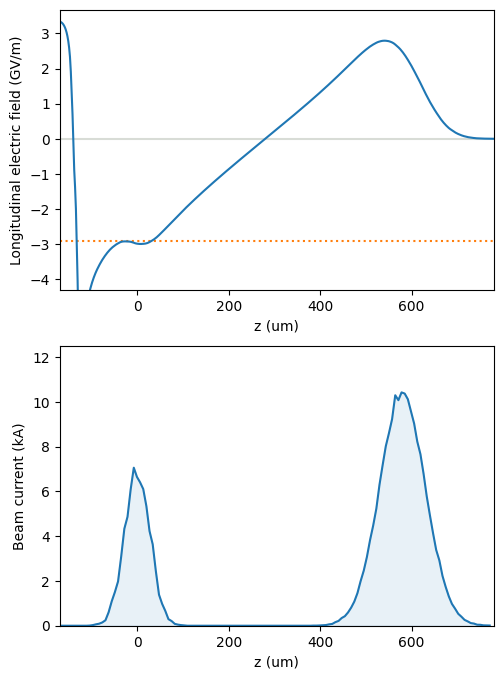

In [5]:
# plot the first-stage wakefield
linac.stages[0].plot_wakefield()

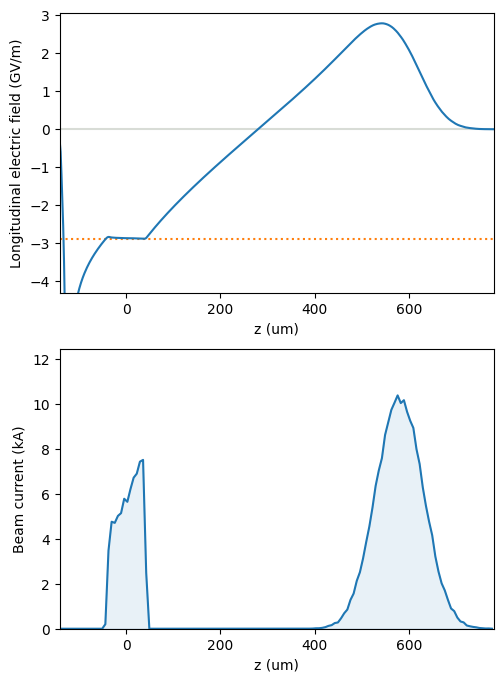

In [6]:
# plot the last-stage wakefield
linac.stages[-1].plot_wakefield()

### Plot beam evolution and survey

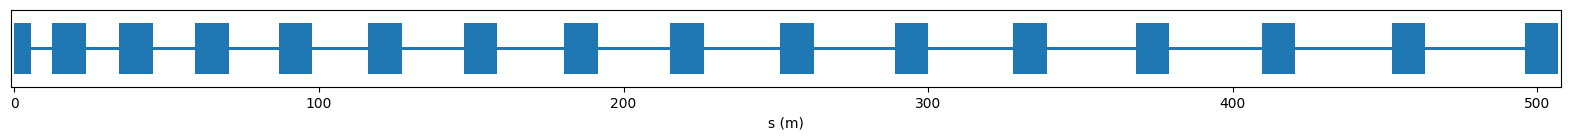

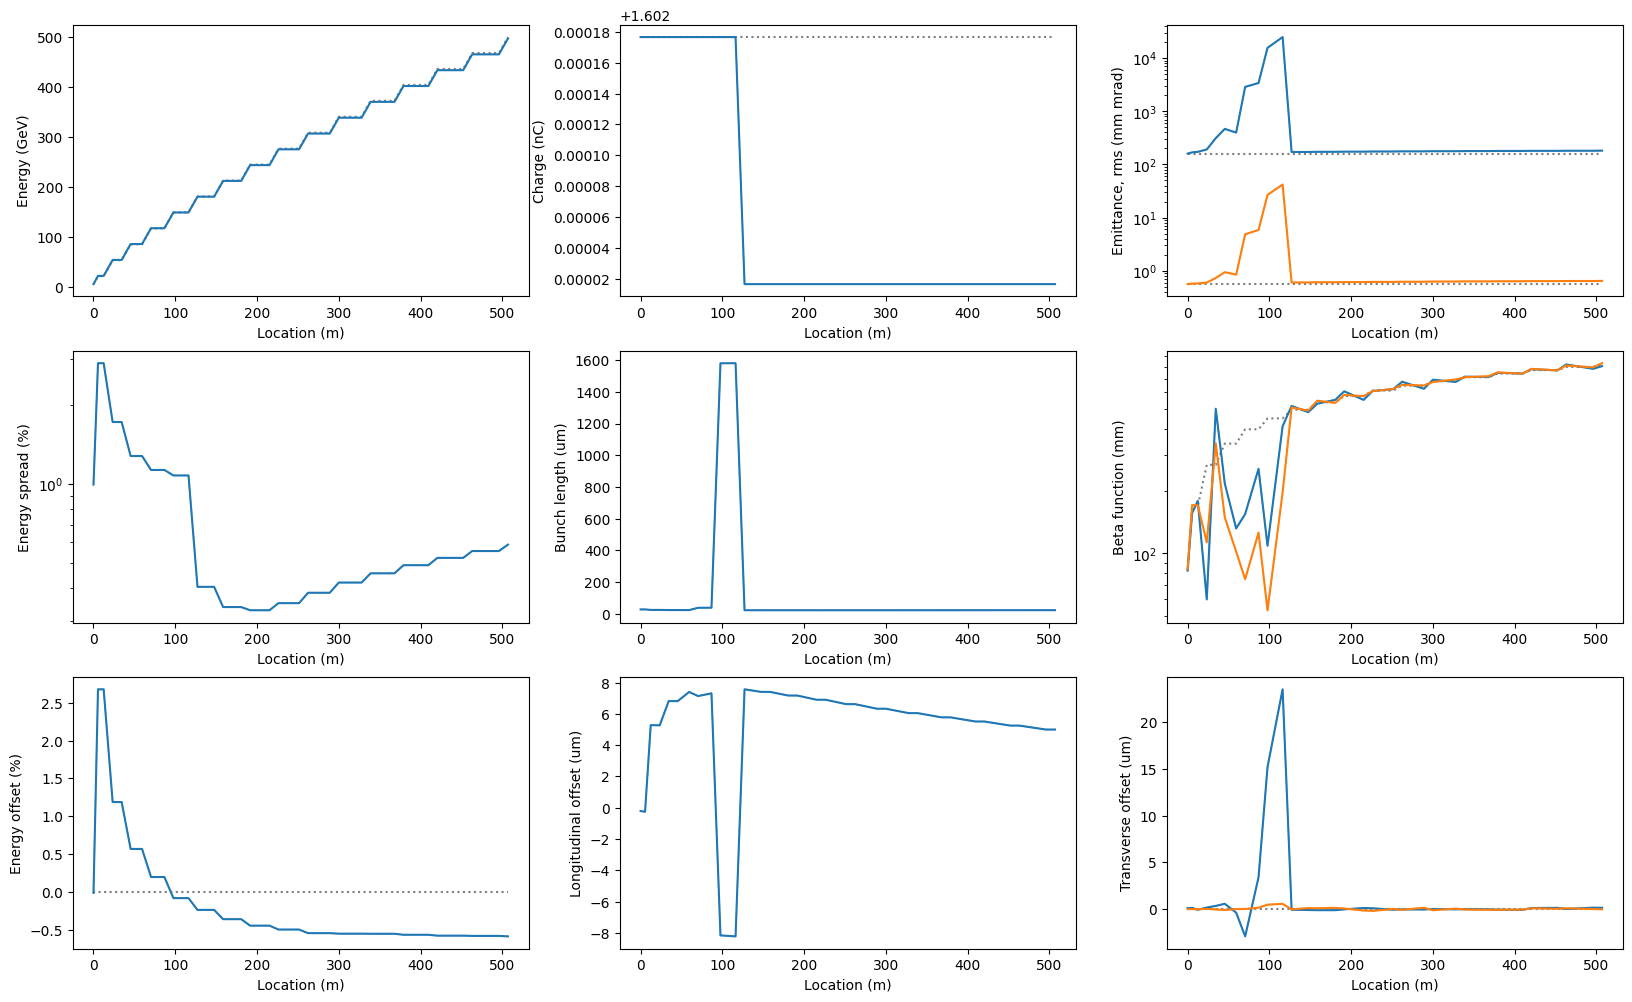

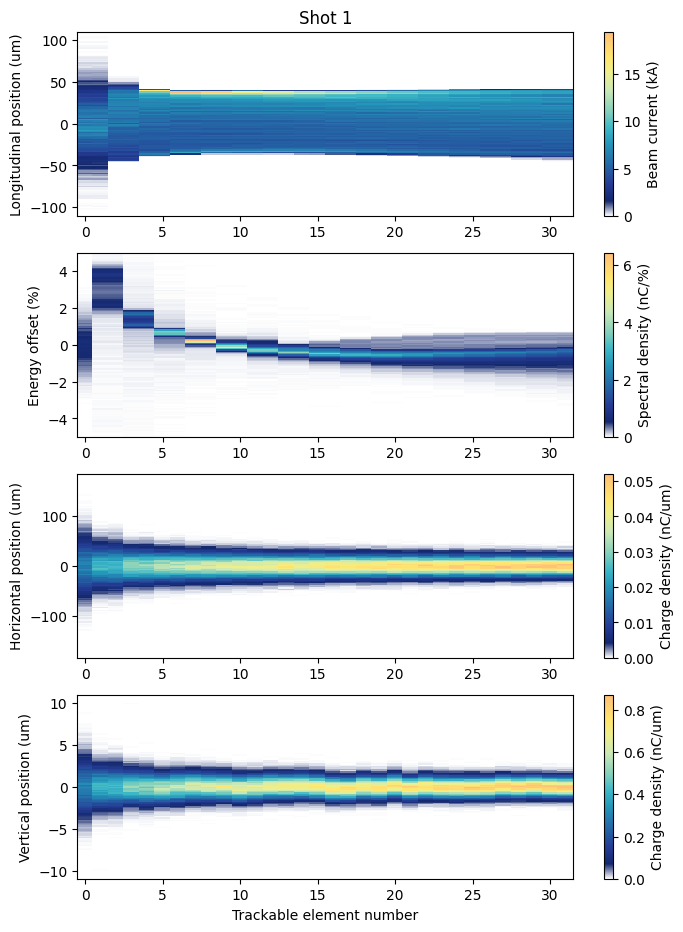

In [7]:
# plot linac survey
linac.plot_survey()

# plot beam evolution
fig_5GeV = linac.plot_evolution(use_stage_nums=False)
#fig_5GeV.savefig(f'Plots_with_updated_params/New_params_ABEL_3_shots{int(source.energy/1e9)}GeV_\
#{int(source.emit_nx*1e6)}mmmrad_{int(source.emit_ny*1e6)}\
#mmmrad_B_{interstage.dipole_field}T_RR_{stage.enable_rr}_11m.png')


linac.plot_waterfalls()

In [8]:
#linac.animate_lps(file_name = f'{interstage.dipole_field}T_5GeV_ex_{source.emit_nx*1e6}_RR_{stage.enable_rr}_jitterx_{driver.jitter.x*1e9}_jittery_{driver.jitter.y*1e9}_nm_weird_results')

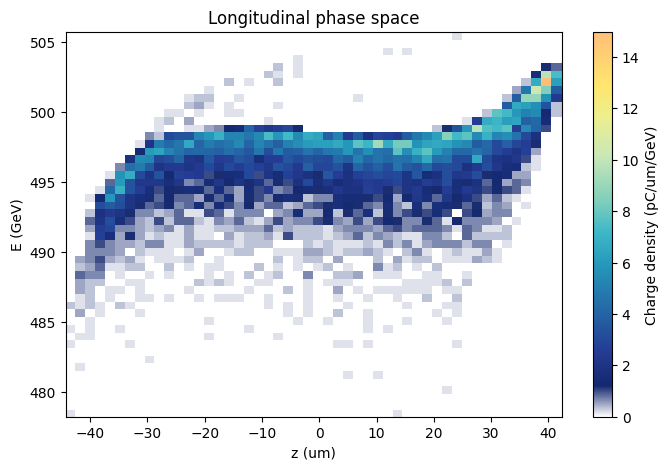

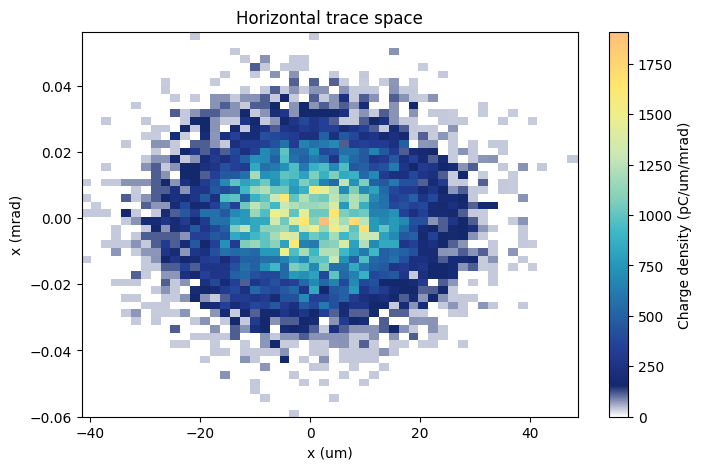

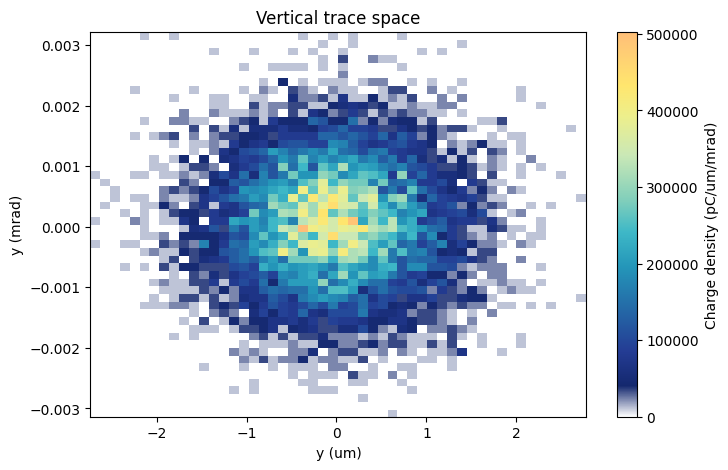

In [9]:
linac.final_beam().plot_lps()

linac.final_beam().plot_trace_space_x()
linac.final_beam().plot_trace_space_y()